In [1]:
## Art Genre Classifier - noob edition
# - using fastai
# - picking a few styles of art and making a classifier for recognizing those styles

In [1]:
#!pip install fastai --upgrade
import fastai 
from fastai.vision.all import *

In [2]:
#use bing image search to get images of paintings
# - abstract
# - western renaissance
# - impressionism ?

### How to use the Bing Image Search API to get a bulk of images


In [2]:
import requests
import matplotlib.pyplot as plt
import os
from PIL import Image
from io import BytesIO

In [3]:
#tricky part here... dont use a cognitive search service for this, use a Bing resource
def bingImageSearch(search_term, img_count = 150):
  '''
  returns a list of urls of images depicting whatever the search term is
  '''
  subscription_key = "44c5a330b8004d5aa27d666390196f6c"
  search_url = "https://api.bing.microsoft.com/v7.0/images/search"

  headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
  params  = {"q": search_term, "count": img_count, "license": "public", "imageType": "photo"}

  response = requests.get(search_url, headers=headers, params=params)
  response.raise_for_status()
  search_results = response.json()
  res = [img["thumbnailUrl"] for img in search_results["value"]]

  return res

In [4]:
abstract = bingImageSearch("abstract art")
impression = bingImageSearch("impressionist paintings")
renaissance = bingImageSearch("renaissance paintings")

In [5]:
#now we have 150 images each of abstract, impressionist, and renaissance paintings
print(f'abstract art count : {len(abstract)} \nimpressionist art count : {len(impression)} \nrenaissance art count: {len(renaissance)}')

abstract art count : 150 
impressionist art count : 150 
renaissance art count: 150


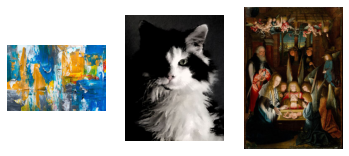

In [6]:
#lets have a look at a random picture from each of the datasets
import random

f, axes = plt.subplots(1, 3)
sample_images = [abstract[random.randint(0,149)], impression[random.randint(0,149)], renaissance[random.randint(0,149)]]

for i in range(3):
  imp_image_data = requests.get(sample_images[i])
  imp_image_data.raise_for_status()
  imp_image = Image.open(BytesIO(imp_image_data.content))

  axes[i].imshow(imp_image)
  axes[i].axis("off")


plt.show()

### Downloading all the images from the URLS and putting them into appropriate label folders

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

base_dir = 'paintings/'
styles = ["abstract", "impressionist", "renaissance"]

#uncomment and run to create the directories
os.mkdir(base_dir)
for style in styles:
  os.mkdir(base_dir+style)

def downloadToFolder(path, urllist):

  for i,url in enumerate(urllist):
    img_data = requests.get(url)
    img_data.raise_for_status() #catches errors
    file = open(base_dir+path+"/"+str(i)+".jpg", 'wb') #change name if you put them all into the same folder
    file.write(img_data.content)
    file.close()

downloadToFolder("abstract", abstract)
downloadToFolder("impressionist", impression)
downloadToFolder("renaissance", renaissance)

### Removing Corrupt Images

In [9]:
#get a list of all the files, check for corrupt files as well
all_files = []

for path,dirname,files in os.walk(base_dir):
  #print(a,b,c)
  for fname in files:
    img_path = os.path.join(path, fname)
    im = Image.open(img_path)
    
    try:
      im.verify()
      all_files.append(img_path)
    except Exception:
      os.unlink(img_path) #can use os.remove() also; removes the path of the corrupted file

    im.close()

len(all_files)

450

### Augmenting the images

In [10]:
#first, we make a dataloader
paintings = DataBlock((ImageBlock, CategoryBlock),   # independent and dependent data types
          get_items = get_image_files,   # fn that retrieves list of images 
          splitter = RandomSplitter(valid_pct = 0.2, seed = 72), #split of data
          get_y = parent_label,          # fn to get the label 
          item_tfms = Resize(128))       # resize each image 

dlrs = paintings.dataloaders(base_dir) #make a dataloaders 

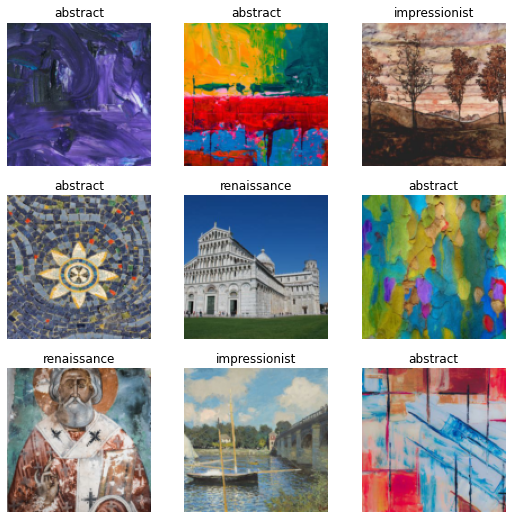

In [11]:
#sample images
dlrs.valid.show_batch()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


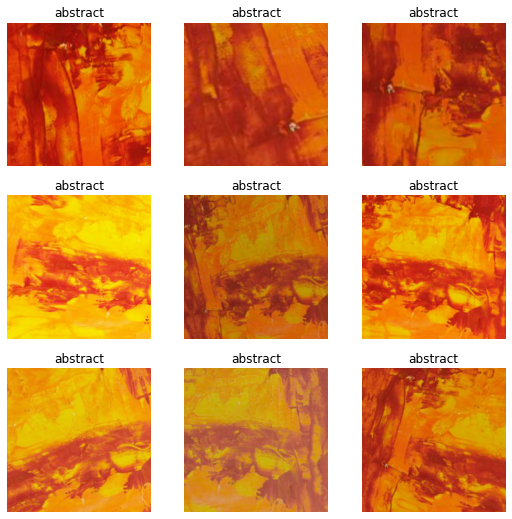

In [12]:
#augment the images : do not warp too much, everything will start to look abstract lol
paintings = paintings.new(item_tfms = RandomResizedCrop(224), batch_tfms=aug_transforms(mult = 2, do_flip = False, max_warp = 0.1))
dlrs = paintings.dataloaders(base_dir)
dlrs.train.show_batch(unique = True)

### Making the model and Training 

In [13]:
#use transfer learning; start with resnet 
learn = cnn_learner(dlrs, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.773038,1.504213,0.344444,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.872586,0.985427,0.300000,00:04
1,0.759749,0.617357,0.222222,00:04
2,0.692566,0.606192,0.222222,00:04
3,0.617857,0.832228,0.222222,00:04
4,0.544248,0.637364,0.200000,00:04
5,0.491049,0.567545,0.144444,00:04
6,0.455331,0.559842,0.144444,00:04
7,0.417476,0.563893,0.155556,00:04
8,0.385910,0.559670,0.144444,00:04
9,0.362451,0.557970,0.144444,00:04


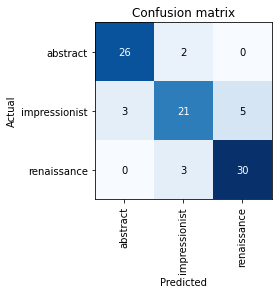

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

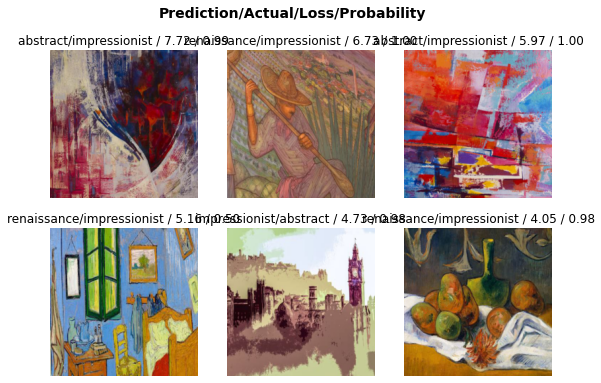

In [15]:
interp.plot_top_losses(6) #tbh i wouldnt know the difference either

### Testing Inference

In [18]:
from ipywidgets import widgets

upload = widgets.FileUpload()
upload
#learn.inference(filename)

FileUpload(value={}, description='Upload')

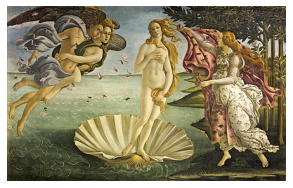

In [28]:
#the uploaded file
img = PILImage.create(upload.data[-1])
img.show()

In [32]:
learn.predict(img)

('renaissance', tensor(2), tensor([6.9372e-05, 7.6942e-05, 9.9985e-01]))

Our prediction is that it is a renaissance painting with high probability. The painting is actually 'Birth of Venus' by Botticelli who is in fact an Italian renaissance painter!